In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df = pd.read_csv('cci_programs_data_reduced.csv' , low_memory=False)
df = df[~df['Reporting Cycle Name'].str.contains('Semi|Mid-Year', na=False)]

df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df.loc[df['Total Project GHGReductions'] == 0, 'cost_per_ton'] = np.nan
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']

project_counties = df.groupby('Project ID Number')['County'].nunique()
df['n_partners'] = df['Project ID Number'].map(project_counties)
df['multi_county'] = (df['n_partners'] > 1).astype(int)
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

south_counties = ["Los Angeles","Orange","San Diego","Riverside","San Bernardino","Imperial","Ventura"]
df['Region_South'] = df['County'].isin(south_counties).astype(int)

df = df.rename(columns={
    'Agency Name': 'Agency_Name',
    'County': 'County'  # keep as is unless renamed too
})



In [2]:
df_clean = df.dropna(subset=['cost_per_ton', 'share_DAC', 'log_funding', 'n_partners'])


In [10]:
df_clean.loc[:, ['ghg_z', 'dac_z']] = scaler.fit_transform(df_clean[['cost_per_ton', 'share_DAC']])


In [11]:
df_clean['goal_divergence'] = (df_clean['ghg_z'] - df_clean['dac_z']).abs()


/tmp/ipykernel_77462/1526723276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['goal_divergence'] = (df_clean['ghg_z'] - df_clean['dac_z']).abs()


In [12]:
model = smf.ols(
    'goal_divergence ~ log_funding + n_partners + multi_county + Region_South + n_partners:Region_South + C(Agency_Name)',
    data=df_clean
).fit(cov_type='HC3')

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        goal_divergence   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1022.
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        17:36:48   Log-Likelihood:                -67309.
No. Observations:               49855   AIC:                         1.347e+05
Df Residuals:                   49839   BIC:                         1.348e+05
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

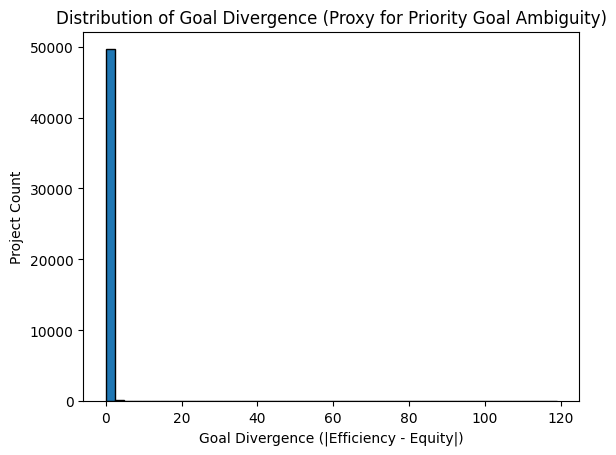

In [9]:
import matplotlib.pyplot as plt

plt.hist(df_clean['goal_divergence'], bins=50, edgecolor='k')
plt.title('Distribution of Goal Divergence (Proxy for Priority Goal Ambiguity)')
plt.xlabel('Goal Divergence (|Efficiency - Equity|)')
plt.ylabel('Project Count')
plt.show()


/tmp/ipykernel_77462/2625904470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['goal_divergence_win'] = winsorize(df_clean['goal_divergence'], limits=[0, 0.01])


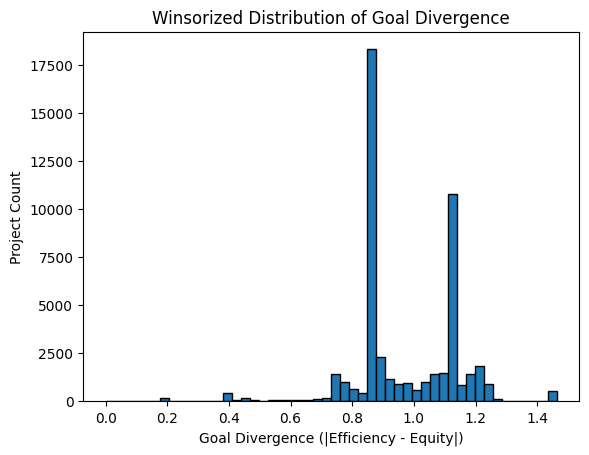

In [13]:
from scipy.stats.mstats import winsorize

df_clean['goal_divergence_win'] = winsorize(df_clean['goal_divergence'], limits=[0, 0.01])
plt.hist(df_clean['goal_divergence_win'], bins=50, edgecolor='k')
plt.title('Winsorized Distribution of Goal Divergence')
plt.xlabel('Goal Divergence (|Efficiency - Equity|)')
plt.ylabel('Project Count')
plt.show()
